# U-net

Ce notebook détaille la mise en œuvre d'un CNN pour la segmentation d'images. L'architecture U-Net est privilégiée pour sa capacité à localiser précisément les objets dans une image.

## Import

In [1]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np

## Préparation des données et du Dataset

Cette classe hérite de l'objet Dataset de PyTorch pour automatiser le chargement des données. Elle assure la lecture des images denses et de leurs masques de segmentation associés. 

In [ ]:
class MulticlassMaskDataset(Dataset):
    # Dataset pour segmentation multiclasse avec mapping global des masques

    def __init__(self, image_dir, mask_dir, max_images=None, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        # Liste des fichiers images
        all_image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        all_image_files.sort()
        
        # Filtrer pour garder uniquement les images ayant des masques correspondants
        self.image_files = []
        for f in all_image_files:
            mask_path = os.path.join(mask_dir, f)
            if os.path.exists(mask_path):
                self.image_files.append(f)
        
        if max_images is not None:
            self.image_files = self.image_files[:max_images]

        # Construire le mapping global de toutes les valeurs uniques
        all_values = set()
        for f in self.image_files:
            mask_path = os.path.join(mask_dir, f)
            mask = np.array(Image.open(mask_path))
            all_values.update(np.unique(mask).tolist())

        self.unique_values = sorted(list(all_values))
        self.n_classes = len(self.unique_values)
        self.value_to_idx = {v: i for i, v in enumerate(self.unique_values)}

        print(f"Mapping global des classes : {self.value_to_idx}")
        print(f"Nombre total de classes : {self.n_classes}")

        # Transformation
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Charger l'image
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('L')
        image = self.transform(image).float()  

        # Charger le masque
        mask_path = os.path.join(self.mask_dir, self.image_files[idx])
        mask = np.array(Image.open(mask_path), dtype=np.int64)

        # Appliquer le mapping global
        mask_new = np.zeros_like(mask, dtype=np.int64)
        for original_value, new_idx in self.value_to_idx.items():
            mask_new[mask == original_value] = new_idx

        mask = torch.from_numpy(mask_new).long()  

        # Global mask 
        global_mask = (mask > 0).float().unsqueeze(0)  

        return image, mask, global_mask

## Définition de l'architecture U-Net

Le modèle repose sur une structure symétrique en forme de U. La partie gauche du réseau réduit la dimension spatiale pour capturer le contexte global de l'image. La partie droite effectue une expansion pour reconstruire la résolution originale. Des connexions spécifiques relient les couches de même niveau. Ces liens permettent de transférer les informations de texture fines perdues lors de la compression. Le modèle final produit une carte de probabilité pour chaque pixel.

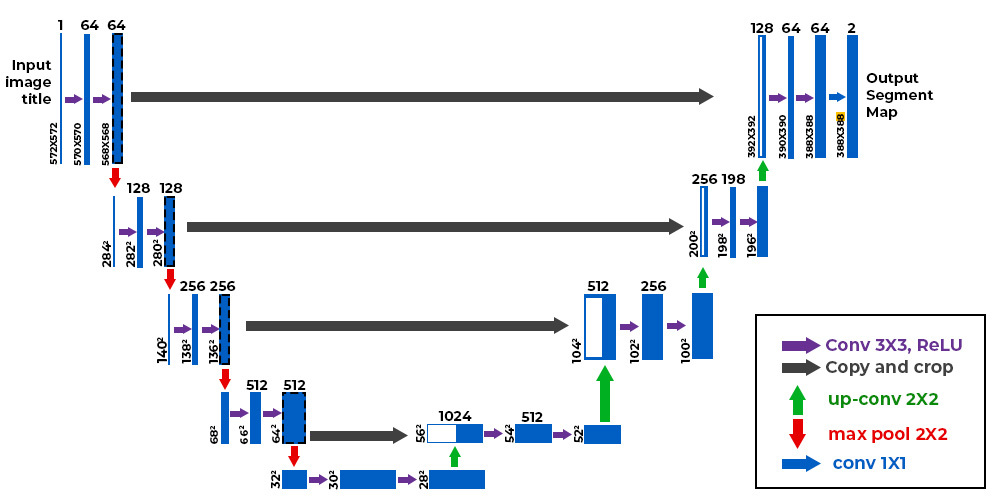

In [3]:
import torch.nn.functional as F
import torch.nn as nn

class DoubleConv(nn.Module):
    """Bloc double convolution Conv2d + BatchNorm + ReLU"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Bloc de downsampling : MaxPool2d + DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Bloc de upsampling : Upsample ou ConvTranspose + DoubleConv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x) 


In [4]:
class FlexibleUNetMulticlass(nn.Module):
    """
    U-Net pour segmentation multi-class.
    Sortie : logits pour n_classes channels (bg=0 + zones).
    """
    def __init__(self, n_channels=1, n_classes=105, bilinear=True):  # n_classes = total incl bg
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        factor = 2 if bilinear else 1

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // factor)

        # Decoder
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

        # Sortie : logits pour chaque classe
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)  # (B, n_classes, H, W)
        return logits

## Loss

In [ ]:
class MulticlassDiceLoss(nn.Module):
    """Calcul de la Dice Loss pour segmentation multi-classes."""
    def __init__(self, n_classes, smooth=1.0):
        super().__init__()
        self.n_classes = n_classes
        self.smooth = smooth

    def forward(self, logits, target):
        probs = F.softmax(logits, dim=1)  
        target_onehot = F.one_hot(target, num_classes=self.n_classes).permute(0, 3, 1, 2).float()

        intersection = (probs * target_onehot).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + target_onehot.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)

        loss = 1. - dice.mean()
        return loss

## Entrainement

Le processus d'apprentissage configure une fonction de perte adaptée à la classification de pixels. Un optimiseur ajuste les poids du réseau à chaque itération pour minimiser cette erreur.

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Hyperparamètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 100
batch_size = 4
learning_rate = 1e-4

# Dataset
dataset = MulticlassMaskDataset(
    image_dir="data/X_train/images",
    mask_dir="data/Supp_train/segmentations/",
    max_images=200
)
n_classes = dataset.n_classes  

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Modèle
model = FlexibleUNetMulticlass(n_channels=1, n_classes=n_classes).to(device)

# Losses 
class_weights = torch.ones(n_classes, device=device)
class_weights[1:] = 10.0 
ce_criterion = nn.CrossEntropyLoss(weight=class_weights)
dice_criterion = MulticlassDiceLoss(n_classes=n_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)

# Entraînement
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks, _ in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        ce_loss = ce_criterion(outputs, masks)
        dice_loss = dice_criterion(outputs, masks)
        loss = 0.5 * ce_loss + 0.5 * dice_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    train_losses.append(epoch_loss)
    scheduler.step(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

print("Entraînement terminé !")

Mapping global des classes : {0: 0, 1: 1, 2: 2, 4: 3, 5: 4, 8: 5, 9: 6, 10: 7, 13: 8, 15: 9, 20: 10, 22: 11, 24: 12, 25: 13, 26: 14, 28: 15, 30: 16, 31: 17, 32: 18, 33: 19, 34: 20, 35: 21, 36: 22, 37: 23, 38: 24, 41: 25, 42: 26, 44: 27, 46: 28, 47: 29, 49: 30, 51: 31, 52: 32, 57: 33, 60: 34, 61: 35, 62: 36, 63: 37, 73: 38, 75: 39, 76: 40, 83: 41, 84: 42, 87: 43, 88: 44, 90: 45, 93: 46, 95: 47, 97: 48, 98: 49, 99: 50, 100: 51, 101: 52, 102: 53, 104: 54}
Nombre total de classes : 55
Epoch 1/10 - Loss: 2.5412
Epoch 2/10 - Loss: 2.4799
Epoch 3/10 - Loss: 2.4224
Epoch 4/10 - Loss: 2.3740
Epoch 5/10 - Loss: 2.3283
Epoch 6/10 - Loss: 2.2691
Epoch 7/10 - Loss: 2.2747
Epoch 8/10 - Loss: 2.2511
Epoch 9/10 - Loss: 2.1763
Epoch 10/10 - Loss: 2.1814
Entraînement terminé !


## Inférence

### Sauvegarde du modèle

In [ ]:
import torch

def save_model_weights(model, save_path, filename):
    # Créer le répertoire si nécessaire
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    save_path = os.path.join(os.path.dirname(save_path), filename)

    # Sauvegarder les poids
    torch.save(model.state_dict(), save_path)
    print(f"Modèle sauvegardé à: {save_path}")

save_model_weights(
    model=model,
    save_path="saved_models/model.pth",
    filename="unet1000im100ep.pth"
)

### Charger un modèle

In [ ]:
def load_model_weights(model, load_path):
    # Charge les poids d'un modèle sauvegardé.
    model.load_state_dict(torch.load(load_path))
    model.eval() 
    print(f"Poids du modèle chargés depuis: {load_path}")
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlexibleUNetMulticlass(n_channels=1, n_classes=105).to(device)
model = load_model_weights(model, "saved_models/best_model.pth")


Poids du modèle chargés depuis: saved_models/best_model.pth


### Visualization

In [ ]:
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

def predict_and_plot_global(model, image_path, dataset, device='cuda'):
    # Affiche l'image originale, le masque global prédit, et le masque réel coloré côte à côte.
    model.eval()
    
    # Charger image
    image = Image.open(image_path).convert('L')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Prédiction
    with torch.no_grad():
        logits = model(image_tensor)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().squeeze(0).numpy()  

    # Génération du masque global prédit coloré
    predicted_classes = np.unique(preds)
    predicted_classes = predicted_classes[predicted_classes != 0]  

    H, W = preds.shape
    global_rgb_pred = np.zeros((H, W, 3))
    colors = plt.cm.rainbow(np.linspace(0, 1, dataset.n_classes))
    for cls_idx in predicted_classes:
        mask_i = (preds == cls_idx)
        global_rgb_pred[mask_i] = colors[cls_idx][:3]

    # Charger et générer le masque réel coloré
    filename = os.path.basename(image_path)
    mask_path = os.path.join(dataset.mask_dir, filename)
    real_mask = np.array(Image.open(mask_path))  

    real_classes = np.unique(real_mask)
    real_classes = real_classes[real_classes != 0]  

    global_rgb_real = np.zeros((H, W, 3))
    for cls_idx in real_classes:
        mask_i = (real_mask == cls_idx)
        global_rgb_real[mask_i] = colors[cls_idx % dataset.n_classes][:3] 

    # Affichage côte à côte (3 subplots)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image_tensor.cpu().squeeze().numpy(), cmap='gray')
    plt.title("Image originale")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(global_rgb_pred)
    plt.title("Masque global prédit")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(global_rgb_real)
    plt.title("Masque réel")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return global_rgb_pred

In [14]:
dataset = MulticlassMaskDataset(
    image_dir="data/X_train/images",
    mask_dir="data/Supp_train/segmentations/",
    max_images=200
)

Mapping global des classes : {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104}
Nombre total de classes : 105


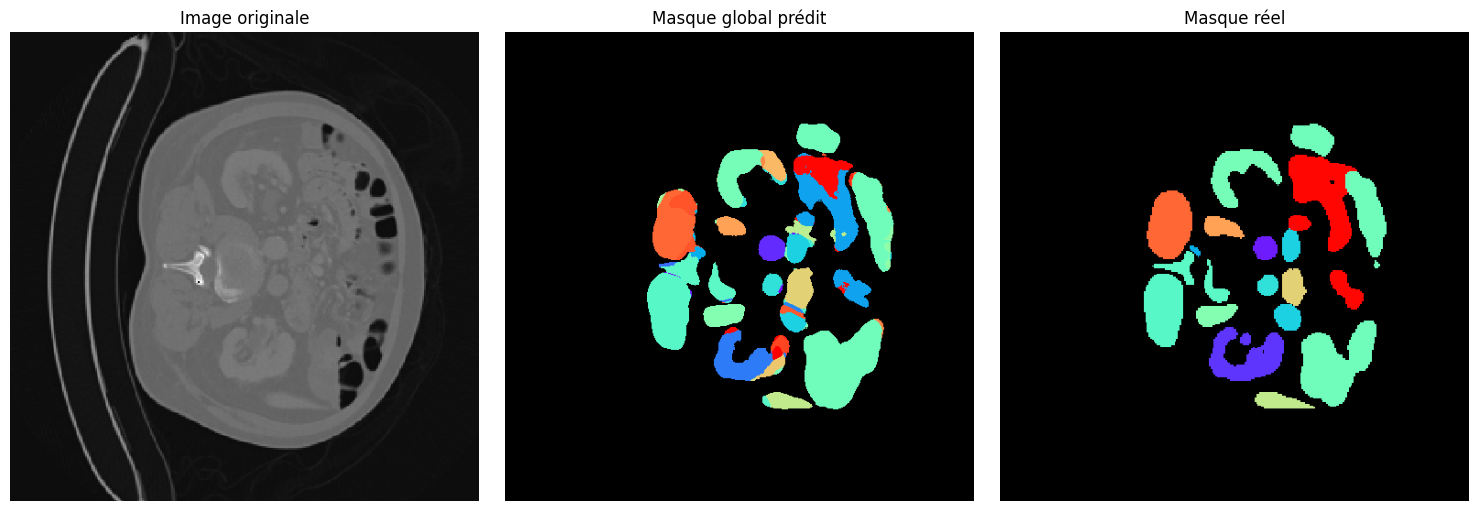

In [15]:
image_path = "data/X_train/images/22.png"
mask_global = predict_and_plot_global(model, image_path, dataset, device=device)

### Evaluation

In [16]:
from sklearn.metrics import adjusted_rand_score
import pandas as pd 

def rand_index_dataset(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the individual rand index for each sample in the dataset and then average it"""
    individual_rand_index = []
    for row_index in range(y_true_df.values.shape[0]):
        labels = y_true_df.values[row_index]
        preds = y_pred_df.values[row_index]
        individual_rand_index.append(adjusted_rand_score(labels, preds))

    return np.mean(individual_rand_index)

In [ ]:
import pandas as pd
import torch
from tqdm import tqdm 

def evaluate_dataset_ari(model, dataset, device='cuda'):
    # Calcule la moyenne de l'Adjusted Rand Index (ARI) sur tout le dataset.
    # Utilise le mapping global du dataset.

    model.eval()
    all_gt = []
    all_pred = []

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    for img_name in tqdm(dataset.image_files, desc="Évaluation ARI"):
        # Charger image et masque
        img_path = os.path.join(dataset.image_dir, img_name)
        mask_path = os.path.join(dataset.mask_dir, img_name)

        image = Image.open(img_path).convert('L')
        gt_mask = np.array(Image.open(mask_path), dtype=np.int64)

        # Appliquer le mapping global sur le masque 
        mask_new = np.zeros_like(gt_mask, dtype=np.int64)
        for original_value, new_idx in dataset.value_to_idx.items():
            mask_new[gt_mask == original_value] = new_idx

        # Préparer tenseur image
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Prédire
        with torch.no_grad():
            logits = model(image_tensor)
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()

        # Aplatir et stocker
        all_gt.append(mask_new.flatten())
        all_pred.append(preds.flatten())

    # Convertir en DataFrames
    y_true_df = pd.DataFrame(all_gt)
    y_pred_df = pd.DataFrame(all_pred)

    # Calcul du score moyen
    ari_mean = rand_index_dataset(y_true_df, y_pred_df)
    print(f"\n ARI moyen sur le dataset : {ari_mean:.4f}")
    return ari_mean


In [18]:
ari_mean = evaluate_dataset_ari(model, dataset, device=device)

Évaluation ARI: 100%|██████████| 200/200 [00:09<00:00, 20.23it/s]



✅ ARI moyen sur le dataset : 0.8840
